In [33]:
###############################################################################################################################################################################################
###### THIS CELL CONFIGURES THE NOTEBOOK, IMPORTS LIBRARIES AND DECLARE GLOBALS THAT ARE USED THROUGHOUT THIS NOTEBOOK. UPDATE ACCORDING DO YOUR CONFIGURATION + WHAT YOU WANT TO PLOT ########
###############################################################################################################################################################################################
import seaborn as sns                                                                                    
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import argparse
import os
import pickle
import numpy as np
from scipy import stats

%matplotlib notebook

pd.set_option('display.max_columns', None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

rate = '50'
exp_base_folder = os.path.join('/home/maxdml/experiments/', rate, '')

pd.set_option('float_format', '{:f}'.format)

core_to_comp = {'1': 'network', '2': 'http'} # This maps a CPU ID to a component in the application (used for PCMs data)

#  EXEC  : instructions per nominal CPU cycle
#  IPC   : instructions per CPU cycle
#  FREQ  : relation to nominal CPU frequency='unhalted clock ticks'/'invariant timer ticks' (includes Intel Turbo Boost)
#  AFREQ : relation to nominal CPU frequency while in active state (not in power-saving C state)='unhalted clock ticks'/'invariant timer ticks while in C0-state'  (includes Intel Turbo Boost)
#  L3MISS: L3 (read) cache misses 
#  L3HIT : L3 (read) cache hit ratio (0.00-1.00)
#  L3MPI : number of L3 (read) cache misses per instruction
#  L2MPI : number of L2 (read) cache misses per instruction
#  READ  : bytes read from main memory controller (in GBytes)
#  WRITE : bytes written to main memory controller (in GBytes)
#  L3OCC : L3 occupancy (in KBytes)
pcm_stats = ['EXEC', 'IPC', 'L3MISS', 'L2MISS', 'L3HIT', 'L3MPI', 'L2MPI', 'L3OCC']
latencies = ['end-to-end', 'send', 'receive']
throughput = ['bps']
dtypes = {
    'latencies': latencies,
    'pcms': pcm_stats,
    'throughput': throughput
}

cache = {}
# cache['exp_name']['latencies']['latency_name']['pickle']
# cache['exp_name']['latencies']['latency_name']['data']
# cache['exp_name']['throughput']
# cache['exp_name']['pcms']

In [48]:
def read_csv(csvfile, reset_time=True, second_ts=True, prune=True):
    df = pd.read_csv(csvfile, delimiter='\t').sort_values('TIME')
    if reset_time:
        df.TIME -= min(df.TIME)
    if second_ts:
        df.TIME /= 1e9
    if prune:
        value_df = df.loc[:, df.columns == 'VALUE']
        high = int(value_df.quantile(q=.9999))
        value_df = value_df.apply(lambda x: x[x < high])
        df = pd.concat([df.loc[:, 'TIME'], value_df], axis=1)
        df.dropna(inplace=True)
    return df

# reset the cache here means replacing the dataframes even if they are cached
def prepare_data(exps, data_types, prune=True, tail=False, reset_cache=False):               
    setups = {}
    for exp in exps:
        setups[exp] = {}
        exp_folder = os.path.join(exp_base_folder, exp, '')
        
        for t in data_types:
            if t == 'latencies':
                setups[exp]['latencies'] = {}
                for lat in dtypes['latencies']:
                    if not reset_cache and 'data' in cache[exp]['latencies'][lat]:
                        setups[exp]['latencies'][lat] = cache[exp]['latencies'][lat]['data']
                    else:
                        filename = os.path.join(exp_folder, 'rate_client', exp + '_' + lat)
                        setups[exp]['latencies'][lat] = read_csv(filename)
                        if prune:
                            setups[exp]['latencies'][lat] = setups[exp]['latencies'][lat][setups[exp]['latencies'][lat].VALUE < setups[exp]['latencies'][lat].VALUE.quantile(.9999)]
                        if tail:
                            setups[exp]['latencies'][lat] = setups[exp]['latencies'][lat][setups[exp]['latencies'][lat].VALUE > setups[exp]['latencies'][lat].VALUE.quantile(.90)]
                        cache[exp]['latencies'][lat]['data'] = setups[exp]['latencies'][lat]
        
            # Ethq data
            if t == 'throughput':    
                if not reset_cache and 'data' in cache[exp]['throughput']:
                    setups[exp]['throughput'] = cache[exp]['throughput']['data']
                else:
                    filename = os.path.join(exp_folder, 'ethq', 'ethq.log')
                    df = pd.read_csv(filename, delimiter='\t')
                    df.time -= min(df.time)
                    df.time /= 1e9
                    df.set_index('time', inplace=True)
                    df = df[df.NIC.isin(['eno5-1', 'eno5-2', 'eno5-5', 'eno5-6']) & ((df.T.drop('NIC') != 0).any())]
                    setups[exp]['throughput'] = df
                    cache[exp]['throughput']['data'] = df
            
            #Hardware Performance Counter monitors
            if t == 'pcms':
                if not reset_cache and 'data' in cache[exp]['pcms']:
                    setups[exp]['pcms'] = cache[exp]['pcms']['data']
                else:    
                    core_to_comp = {'1': 'network', '2': 'http', '3': 'http'}
                    
                    filename = os.path.join(exp_folder, 'pcm', 'pcm.csv')
                    raw_pcm_df = pd.read_csv(filename, delimiter=';', skiprows=1)
                    raw_pcm_df.Time = pd.to_datetime(raw_pcm_df.Time).values.astype(np.int64) // 10**9
                    raw_pcm_df.Time -= min(raw_pcm_df.Time)

                    cols = ['Date', 'Time']
                    for core in core_to_comp.keys():
                        new_cols = [stat+'.{}'.format(core) for stat in pcm_stats]
                        cols.extend(new_cols)
                    setups[exp]['pcms'] = raw_pcm_df[cols]
                    cache[exp]['pcms']['data'] = setups[exp]['pcms']

# Apparently those are disk cache stats...
#         cachestats_filename = exp_folder + 'cachestat/cachestats.csv'
#         df = pd.read_csv(cachestats_filename, delimiter='\t')
#         df.dropna(inplace=True)
#         df['WRITE_HIT%'] = df['WRITE_HIT%'].apply(lambda x: float(x.strip('%')))
#         df['READ_HIT%'] = df['READ_HIT%'].apply(lambda x: float(x.strip('%')))
#         df = df[(df.HITS > 0) | (df.MISSES > 0) | (df.DIRTIES > 0) | (df['READ_HIT%'] > 0) | (df['WRITE_HIT%'] > 0)]
#         setups[exp]['cachestats'] =  df
#         setups[exp]['cachestats'].TIME -= min(setups[exp]['cachestats'].TIME)
    
    return setups

def setup_cache(exps, data_types):
    for exp in exps:
        cache[exp] = {}
        for t in data_types:
            cache[exp][t] = {}
            for dtype in dtypes[t]:
                cache[exp][t][dtype] = {}

#reset the cache here means refreshing the entries for the given exps and data_types
def plot_all(exps, data_types=[], reset_cache=False, stacking=True):
    if (len(data_types) == 0):
        data_types = ['latencies', 'throughput', 'pcms']

    if reset_cache:
        setup_cache(exps, data_types)

    setups = prepare_data(exps, data_types)

    reset_cache = True #FIXME: Pickling does not work as intended as of now

    # First compute layout for the figure
    if stacking:
        ncols = 1
    else:
        ncols = len(setups)

    for i, t in enumerate(data_types):
        # Instantiate the figure
        plt.figure(i+1)
        fig, axs = plt.subplots(len(dtypes[t]), ncols, squeeze=False, sharey=False, sharex=False, num=i+1)   
        for j, setup in enumerate(setups.keys()):
            c_index = j % ncols

            if t == 'latencies':
                if not reset_cache and 'pickle' in cache[setup][t][lat] and os.path.getsize(cache[setup][t][lat]['pickle']) > 0:
#                     fig.delaxes(axs[0][index])
#                     pickle.load(open(cache[setup][t]['pickle'], 'rb'))
                    pass
                else:
                    for r_index, lat in enumerate(dtypes[t]):
                        sns.distplot(setups[setup][t][lat].VALUE, ax=axs[r_index][c_index], label=setup, kde=True, kde_kws=dict(cumulative=True), bins=100)
                        axs[r_index][c_index].set(xlabel='latency (ns)', ylabel='#requests')
                        if stacking:
                            axs[r_index][c_index].set_title('{} latency'.format(t))
                        else:
                            axs[r_index][c_index].set_title('{} latency: {}'.format(t, setup))

                        axs[r_index][c_index].ticklabel_format(style='plain')
                        axs[r_index][c_index].legend()

#                         pickle.dump(axs[r_index], open(setup + '-' + t + '.pickle', 'wb'))
#                         cache[setup][t]['pickle'] = setup + '-' + t + '.pickle'

            if t == 'pcms':
                for i in range(len(dtypes[t])):
                    stat_names = [dtypes[t][i]+'.{}'.format(core_id) for core_id in core_to_comp.keys()]
                    for c, stat in enumerate(stat_names):
                        sns.scatterplot(x = setups[setup][t].Time, y=stat, data=setups[setup][t], palette='colorblind', ax=axs[i][c_index], legend=False)
                        axs[i][c_index].set(xlabel='Time')
                        axs[i][c_index].set_title('{}'.format(stat), fontsize=6)
                        ylimit = max(setups[setup][t][stat]) + max(setups[setup][t][stat]) * 0.1
                        axs[i][c_index].set_ylim(0, ylimit)
                        axs[i][c_index].set_ylabel('')

#             if t == 'throughput':               
#                 # Merge all the throughput DF together. Hue will be setup
#                 tps = []
#                 for setup in setups:
#                     setups[setup]['throughput']['exp'] = setup     
#                     tps.append(setups[setup]['throughput'])
#                 df = pd.concat(tps)
#                 fig, axs = plt.subplots(1, 2, squeeze=False, sharey=False)
#                 sns.lineplot(x=df.index, y='TX Mbps', hue='exp', data=df, ax=axs[0][0], ci=None)
#                 sns.lineplot(x=df.index, y='RX Mbps', hue='exp', data=df, ax=axs[0][1], ci=None)

Automatic pdb calling has been turned OFF


<IPython.core.display.Javascript object>


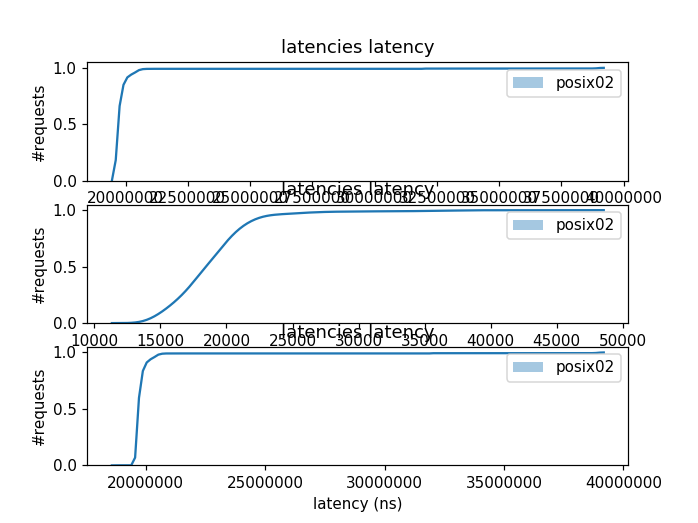

<IPython.core.display.Javascript object>


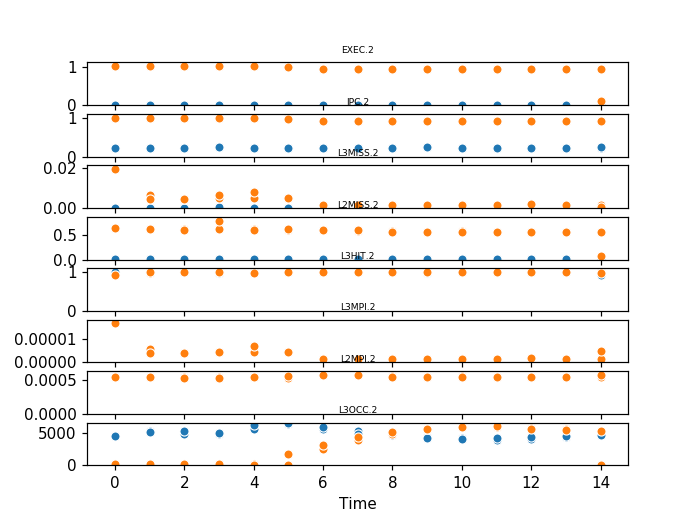

In [49]:
exps = ['posix02']
data_types = ['latencies', 'pcms']
plot_all(exps, data_types, reset_cache=True)

In [ ]:
###############VRAC



        ###### Cachestat numbers
    #     cols = s[exps[0]]['cachestats'].drop('TIME', axis=1).columns
    #     fig, axs = plt.subplots(len(cols), len(exps), squeeze=False, sharex=True)
    #     for i, setup in enumerate(s.keys()):
    #         for j, col in enumerate(cols):
    #             sns.scatterplot(x = s[setup]['cachestats'].TIME, y=col, data=s[setup]['cachestats'], palette='colorblind', ax=axs[j][i])
    #             if i > 0:
    #                 axs[j][i].set(xlabel='Timestamp (s)', ylabel='')
    #             else:
    #                 axs[j][i].set(xlabel='Timestamp (s)', ylabel='{}'.format(col))
    #         axs[0][i].set_title('Cache statistics: {}'.format(setup))

        ###### other types of plots for latencies

    #             fig, axs = plt.subplots(1, len(exps), squeeze=False, sharey=True)
    #             for i, setup in enumerate(setups.keys()):
    #                 sns.scatterplot(x = setups[setup]['e2e'].TIME, y='VALUE', data=setups[setup]['e2e'], palette='colorblind', ax=axs[0][i])
    #                 axs[0][i].set(xlabel='Timestamp', ylabel='latency (ns)')
    #                 axs[0][i].set_title('End to end latency: {}'.format(setup))
    #             fig, axs = plt.subplots(1, len(exps), squeeze=False, sharey=True, sharex=True)
    #             for i, setup in enumerate(setups.keys()):
    #                 sns.boxplot(x=setups[setup]['e2e'].VALUE, ax=axs[0][i])
    #                 axs[0][i].set(xlabel='latency (ns)')
    #                 axs[0][i].set_title('End to end latency: {}'.format(setup))